<a href="https://colab.research.google.com/github/splAcharya/Extractive_Text_Summarization/blob/main/ExTs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Extractive Text Summarization Of Wikipedia Articles

## Install Packages (if needed)

In [1]:
#gensim
!pip install --upgrade gensim

#rouge scorer
!pip install rouge-score

## Import Required Libraries

In [1]:
import time
import re
import urllib.request
from bs4 import BeautifulSoup as bs

import string
pm_set = set(list(string.punctuation))

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
sw_set = set(stopwords.words("english"))

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
import gensim.downloader
from gensim.models import Phrases

import multiprocessing
num_cores = multiprocessing.cpu_count()
print(f"Number of Cores: {num_cores}")

from wordcloud import WordCloud
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from sklearn.utils.extmath import randomized_svd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD as LSA, LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans

from copy import deepcopy
from rouge_score import rouge_scorer
import pandas as pd
from collections import Counter, defaultdict


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Number of Cores: 2


## Function to Webscrape Wikipedia Article

In [2]:
def fetch_wikipedia_article(url="https://en.wikipedia.org/wiki/USA"):
    scrapped_data = urllib.request.urlopen(url)
    article = scrapped_data.read()
    parsed_article = bs(article,"lxml")
    paragraphs = parsed_article.find_all("p")
    article_text = ""
    for p in paragraphs:
        article_text += p.text
    return article_text

## Function to Pre-process Web Scraped Wikipedia Article

In [3]:
def preprocess_article(article, min_length = 5):
    article_lc = article.lower()#lower case entire article
    article_st = sent_tokenize(article_lc)#convert to sentences
    lmtzr = WordNetLemmatizer()#instantiate lemmatize
    pp_article_st = []
    final_article_st = []
    for sentence in article_st:
        original_sentence = deepcopy(sentence)
        #print(sentence)
        sentence = re.sub(r"[\(.*\)]"," ", sentence)#remove data betweena nd include round backers()
        #print(sentence)
        sentence = re.sub(r"\n","",sentence) #remove "\n" characters
        #print(sentence)
        sentence = re.sub(r"\[\d+\]"," ",sentence)#remove refrences [n]
        #print(sentence)
        sentence = re.sub(r"\[.+\]"," ",sentence) #remove anything between [] including []
        #print(sentence)
        sentence = re.sub(r"[^a-zA-z0-9]", " ", sentence) #remove any non english characters
        #print(sentence)
        sentence = re.sub(r"\s+"," ",sentence) #remove any whitespaces, tabs, newline charaacters
        #print(sentence)
        sentence = [lmtzr.lemmatize(word) for word in word_tokenize(sentence) if word not in sw_set ]
        if len(sentence) >= min_length:
            sentence = (" ").join(sentence)
            pp_article_st.append(sentence)
            final_article_st.append(original_sentence)
    return final_article_st, pp_article_st

## Using the two function above to extract Wikipedia Article about USA

In [4]:
article_text = fetch_wikipedia_article("https://en.wikipedia.org/wiki/USA")
article_st, pp_article_st = preprocess_article(article_text)
pp_article_st_wt = [word_tokenize(sent) for sent in pp_article_st]

In [5]:
pp_string = (" ").join(pp_article_st)

In [6]:
article_st[0]

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.'

In [7]:
pp_article_st[0:5]

['coordinate mw parser output geo default mw parser output geo dm mw parser output geo dec display inline mw parser output geo nondefault mw parser output geo multi punct display none mw parser output longitude mw parser output latitude white space nowrap 40 n 100 w 40 n 100 w 40 100the united state america u usa commonly known united state u u america country primarily located north america',
 'consists 50 state federal district five major unincorporated territory 326 indian reservation minor possession',
 'nearly 3 8 million square mile 9 8 million square kilometer world third fourth largest country geographic area',
 'united state share significant land border canada north mexico south well limited maritime border bahamas cuba russia',
 'population 331 million people third populous country world']

## Generate Word Clouds For Raw and Preprocessed Wikipedia Article about USA

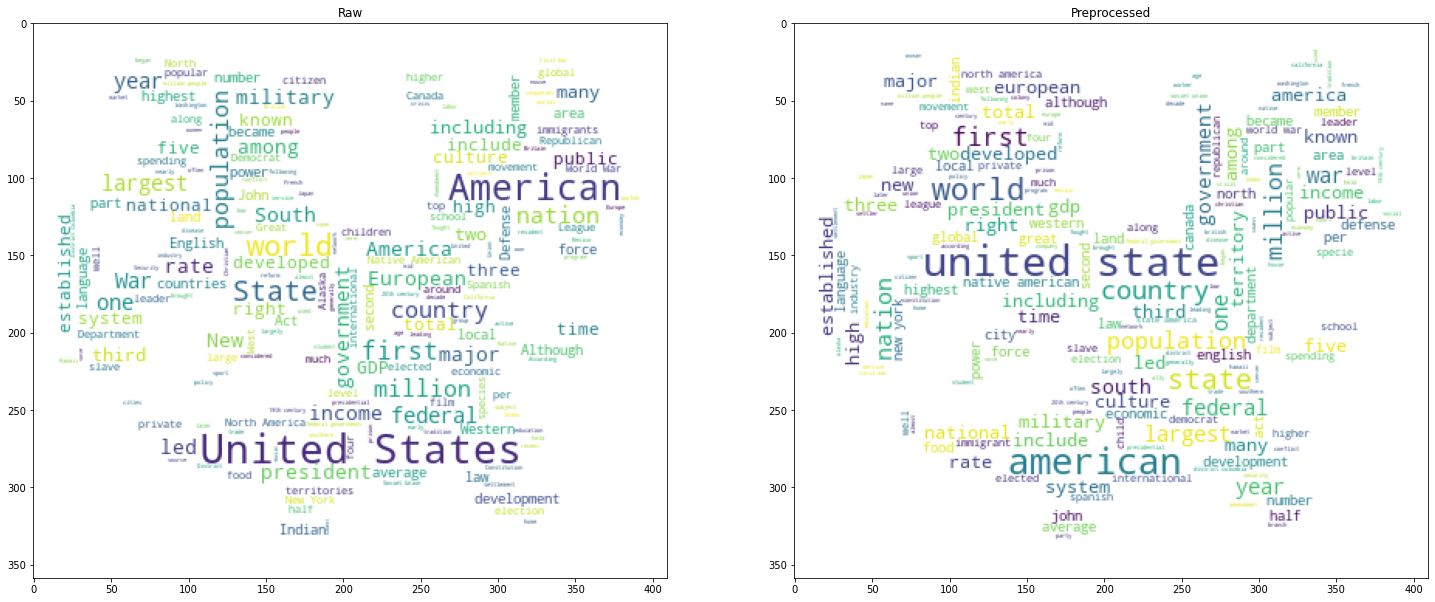

In [8]:
wc_mask = np.array(Image.open(urllib.request.urlopen("http://pm1.narvii.com/5750/abb7fdf1f24f9515a1f1d16e6f05d3f03110c51f_00.jpg")))
wc = WordCloud(background_color="white",mask=wc_mask)
fig, ax = plt.subplots(1,2,figsize=(25,25))
ax[0].imshow(wc.generate(article_text))
ax[0].title.set_text("Raw")
ax[1].imshow(wc.generate(pp_string))
ax[1].title.set_text("Preprocessed")
plt.show()

## LSA Summary Generators

### Function to Generate BOW + LSA Summary

In [9]:
def generate_bow_lsa_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple)
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens)
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))
  top_scores_index = np.argsort(sentence_scores)[::-1]
  top_scores_index = top_scores_index[0:summary_size]
  article_array = np.array(raw_sent_tokens)
  bow_sum = list(article_array[top_scores_index])
  bow_sum_str = " ".join(bow_sum)
  return bow_sum_str

### Function to Generate TF-IDF + LSA Summary

In [10]:
def generate_tfidf_lsa_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple)
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens)
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))
  top_scores_index = np.argsort(sentence_scores)[::-1]
  top_scores_index = top_scores_index[0:summary_size]
  article_array = np.array(raw_sent_tokens)
  tfidf_sum = list(article_array[top_scores_index])
  tfidf_sum_str = " ".join(tfidf_sum)
  return tfidf_sum_str

### Function to Generate Word Embedding + LSA Summary

In [11]:
def create_word_to_vec_model(pp_sent_tokens, ngram=1):

  #create work tokens
  pp_article_st_wt = [word_tokenize(sent) for sent in pp_sent_tokens]

  if ngram <= 1:
    w2v_model = Word2Vec(sentences=pp_article_st_wt,
                        min_count = 5, 
                        window = 5,
                        vector_size=10,
                        sample=6e-5,
                        alpha=0.001,
                        min_alpha = 0.0007,
                        negative=20,
                        workers=num_cores-2)   
    return w2v_model

  else:
    #create n gram phraser
    ngram_model = None
    for i in range(2, ngram+1):
      ngram_model = gensim.models.phrases.Phrases(pp_article_st_wt)

    #create wor2vec model
    w2v_model = Word2Vec(sentences=ngram_model[pp_article_st_wt],
                          min_count = 5, 
                          window = 5,
                          vector_size=10,
                          sample=6e-5,
                          alpha=0.001,
                          min_alpha = 0.0007,
                          negative=20,
                          workers=num_cores-2)  

    return w2v_model

In [12]:
def generate_wemb_lsa_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe 
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += np.median(w2v_model.wv[word])
        freq_map[word] -= 1  

  feature_vector = dte_df.to_numpy()
  U, SIGMA, VT = randomized_svd(feature_vector, n_components = summary_size, n_iter = 100, random_state =100)
  sentence_scores = np.sqrt(np.dot(U**2, SIGMA**2))
  top_scores_index = np.argsort(sentence_scores)[::-1]
  top_scores_index = top_scores_index[0:summary_size]
  article_array = np.array(raw_sent_tokens)
  wemb_sum = list(article_array[top_scores_index])
  wemb_sum_str = " ".join(wemb_sum)
  return wemb_sum_str

### Function to Generated BOW + LSA + K-Means Summary

In [13]:
def generate_bow_lsa_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) #intialize BOW model
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) #train and fit BoW Model
  dimention_reduction_model = LSA(n_components = summary_size, n_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)


### Function to Generated TF-IDF + LSA + K-Means Summary

In [14]:
def generate_tfidf_lsa_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple) #intialize TF-IDF model
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens) #train and fit TF-IDF Model
  dimention_reduction_model = LSA(n_components = summary_size, n_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)

### Function to Generated Word-Embeddings + LSA + K-Means Summary

In [15]:
def generate_wemb_lsa_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe 
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += np.median(w2v_model.wv[word])
        freq_map[word] -= 1  

  feature_vector = dte_df.to_numpy()
  dimention_reduction_model = LSA(n_components = summary_size, n_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)  

## LDA Summary Generators

### Function to Generate BOW + LDA Summary

In [16]:
def generate_bow_lda_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):

  #get BOW Features
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) #intialize
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) #generate
  print("BOW Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic_vector, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  return "".join(summary)
  #return summary

### Function to Generate TF-IDF + LDA Summary

In [17]:
def generate_tfidf_lda_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):

  #get TFIDF Features
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple)
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens)
  print("BOW Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic_vector, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  return "".join(summary)

### Function to Generate Word Embedding + LDA Summary

In [18]:
def generate_wemb_lda_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe for feature vector
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += abs(np.median(w2v_model.wv[word]))
        freq_map[word] -= 1  

  #convert feature vector from dataframe to numpy
  feature_vector = dte_df.to_numpy()
  print("Wemb Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic_vector, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  return "".join(summary)

### Function to Generated BOW + LDA + K-Means Summary

In [19]:
def generate_bow_lda_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) #intialize BOW model
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) #train and fit BoW Model
  dimention_reduction_model = LDA(n_components = summary_size, max_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)


### Function to Generated TF-IDF + LDA + K-Means Summary

In [20]:
def generate_tfidf_lda_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):
  tfidf_vectorizer = TfidfVectorizer(ngram_range=ngram_tuple) #intialize TF-IDF model
  feature_vector = tfidf_vectorizer.fit_transform(pp_sent_tokens) #train and fit TF-IDF Model
  dimention_reduction_model = LDA(n_components = summary_size, max_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)

### Function to Generate Word-Embeddings + LDA + K-Means Summary

In [21]:
def generate_wemb_lda_kmeans_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram = 1):

  #get word 2 vec model
  w2v_model = create_word_to_vec_model(pp_sent_tokens, ngram)#get w2v model
  
  #get word 2 vec model
  words = list(w2v_model.wv.index_to_key)
  word_emb_list = sorted(words)

  #create pandas dataframe 
  document_term_emb = np.zeros(shape=(len(pp_article_st_wt), len(word_emb_list)))
  dte_df = pd.DataFrame(document_term_emb)
  dte_df.columns = word_emb_list
  for i in range(len(pp_article_st)):
    freq_map = Counter(pp_article_st[i])
    for word in word_emb_list:
      if freq_map[word] > 0:
        dte_df[word].iloc[i] += np.abs(np.median(w2v_model.wv[word]))
        freq_map[word] -= 1  

  feature_vector = dte_df.to_numpy()
  dimention_reduction_model = LDA(n_components = summary_size, max_iter = 100, random_state =100) #initialize LSA model
  reduced_feature_vector = dimention_reduction_model.fit_transform(feature_vector) #train and fit LSA model
  clustering_model = KMeans(n_clusters=summary_size, random_state=0, max_iter=500) #initialize K Means model
  clustering_model.fit(reduced_feature_vector) #train and fir clustering model
  cluster_centers = clustering_model.cluster_centers_ #get cluster centers

  #generate summary based on "summary_size" number of clusters
  #sentecens with value closest to each cluster centers are picked
  summary_sentences = []
  for i in range(cluster_centers.shape[0]):
    distances = np.linalg.norm(cluster_centers[i] - reduced_feature_vector, axis=1)
    sorted_indices = np.argsort(distances)
    summary_sentences.append(article_st[sorted_indices[0]])

  return "".join(summary_sentences)  

## Number of Lines in Summary

In [22]:
N_LINE = 10

## Generate Summaries for Uni-GRAM (1-GRAM) Occurence

### LSA

#### BOW

In [23]:
bow_lsa_1gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (1,1))
bow_lsa_1gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. [421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by the cdc since 2003, the first overall decline since 2018, and "the largest one-year decline since world war ii." other languages spoken at home by one million people or more include chinese (2

#### TF-IDF

In [24]:
tfidf_lsa_1gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (1,1))
tfidf_lsa_1gram_summary

"other languages spoken at home by one million people or more include chinese (2.8 million), tagalog (1.6 million), vietnamese (1.4 million), french (1.3 million), korean (1.1 million), and german (1 million). the united states is one of the few countries in the world to do so. the spanish–american war and world war i established the u.s. as a world power, and the aftermath of world war ii left the united states and the soviet union as the world's two superpowers. the united states has the world's largest christian population. the district of columbia and the five major u.s. territories do not have senators. [231] the states and the district of columbia choose the president of the united states. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. by value, the united states is the world's largest importer and second-largest exporter of goods. [22] with a population of more than 331 million people, it is th

#### Word-Embeddings

In [25]:
wemb_lsa_1gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 1)
wemb_lsa_1gram_summary

'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. [195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species. [421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by the cdc since 2003, the first overall decline since 2018, and "the largest one-year decline since world war ii." notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of al

#### K-Means

##### BOW

In [26]:
bow_lsa_kmeans_1gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (1,1))
bow_lsa_kmeans_1gram_summary

'since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992.each state holds jurisdiction over a defined geographic territory, where it shares sovereignty with the federal government.[519] in more recent times, directors such as steven spielberg, george lucas and james cameron have gained renown for their blockbuster films, often characterized by high production costs and earnings.\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:no

##### TF-IDF

In [27]:
tfidf_lsa_kmeans_1gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (1,1))
tfidf_lsa_kmeans_1gram_summary

'[210] the country joined the paris agreement on climate change in 2016 and has many other environmental commitments.[111] this period eventually ended with the advent of the progressive era, which saw significant reforms including women\'s suffrage, alcohol prohibition, regulation of consumer goods, and greater antitrust measures to ensure competition and attention to worker conditions.[342][343] prior to the 2019–2021 global sars-cov-2 pandemic, credit suisse listed some 18.6 million u.s. citizens as having a net worth in excess of $1 million.[382]\nas of 2019[update], the united states receives approximately 80% of its energy from fossil fuels.each state has presidential electors equal to the number of their representatives and senators in congress; the district of columbia has three because of the 23rd amendment.tensions with britain remained, however, leading to the war of 1812, which was fought to a draw.european missionaries and others felt it was important to "civilize" the nat

##### Word-Embeddings

In [28]:
wemb_lsa_kmeans_1gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 1)
wemb_lsa_kmeans_1gram_summary

'alzheimer\'s disease, substance use disorders, kidney disease, cancer, and falls caused the most additional years of life lost over their age-adjusted 1990 per-capita rates.[210] the country joined the paris agreement on climate change in 2016 and has many other environmental commitments."[32] in june 1776, thomas jefferson wrote the phrase "united states of america" in all capitalized letters in the headline of his "original rough draught" of the declaration of independence.[466] mainstream american culture is a western culture largely derived from the traditions of european immigrants with influences from many other sources, such as traditions brought by slaves from africa.[173] in 2020, in what was seen as a repudiation of trump\'s divisive leadership, democrat joe biden was elected as the 46th president.the industry enjoyed its golden years, in what is commonly referred to as the "golden age of hollywood", from the early sound period until the early 1960s,[515] with screen actors 

### LDA

#### BOW

In [29]:
bow_lda_1gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (1,1))
bow_lda_1gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[44] anthropologist henry f. dobyns believed the populations were much higher, suggesting around 1.1 million along the shores of the gulf of mexico, 2.2 million people living between florida and massachusetts, 5.2 million in the mississippi valley and tributaries, and around 700,000 people in the florida peninsula.they persisted until the compromise of 1877 when the republicans agreed to cease protecting the rights of african americans in the south in order for democrats to concede the presidential election of

#### TF-IDF

In [30]:
tfidf_lda_1gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (1,1))
tfidf_lda_1gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'[33]\nit has been generally accepted that the first inhabitants of north america migrated from siberia by way of the bering land bridge and arrived at least 12,000 years ago; however, some evidence suggests an even earlier date of arrival.the first documented arrival of europeans in the continental united states is that of spanish conquistadors such as juan ponce de león, who made his first expedition to florida in 1513. even earlier, christopher columbus had landed in puerto rico on his 1493 voyage, and san juan was settled by the spanish a decade later.[86] the 1803 louisiana purchase almost doubled the nation\'s area,[87] spain ceded florida and other gulf coast territory in 1819,[88] the republic of texas was annexed in 1845 during a period of expansionism,[89] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest.they persisted until the compromise of 1877 when the republicans agreed to cease protecting the rights of african americans i

#### Word-Embeddings

In [31]:
wemb_lda_1gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 1)
wemb_lda_1gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'[175]\nthe 48 contiguous states and the district of columbia occupy a combined area of 3,119,885 square miles (8,080,470\xa0km2).of this area, 2,959,064 square miles (7,663,940\xa0km2) is contiguous land, composing 83.65% of total u.s. land area.[195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species.[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011.[356][357][358]\nthere were about 567,715 sheltered and unsheltered homeless persons in the u.s. in january 2019, with almost two-thirds staying in an emergency shelter or transitional housing program[359] attempts to combat homelessness include the section 8 housing voucher program and implementation of the housing first strategy across all levels of 

#### K-Means

##### BOW

In [32]:
bow_lda_kmeans_1gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (1,1))
bow_lda_kmeans_1gram_summary

"hawaii and the southern tip of florida are tropical, as well as its territories in the caribbean and the pacific.[107] american samoa was acquired by the united states in 1900 after the end of the second samoan civil war.[396] many u.s. metropolitan populations are growing rapidly, particularly in the south and west.[525] the central hub of the american theater scene has been manhattan, with its divisions of broadway, off-broadway, and off-off-broadway.citizenship is granted at birth in all states, the district of columbia, and all major u.s. territories except american samoa.[415] the survey also reported that 22.8% of americans described themselves as agnostic, atheist or simply having no religion—up from 8.2% in 1990.[198] altogether, the government owns about 28% of the country's land area,[199] mostly in the western states.[207] the idea of wilderness has shaped the management of public lands since 1964, with the wilderness act.[399] in 2013, the average age at first birth was 26

##### TF-IDF

In [33]:
tfidf_lda_kmeans_1gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (1,1))
tfidf_lda_kmeans_1gram_summary

'[229] the supreme court, led by the chief justice of the united states, has nine members, who serve for life.[314]\nthe united states is the largest importer of goods and second-largest exporter,[315] though exports per capita are relatively low.[178] measured by only land area, the united states is third in size behind russia and china, just ahead of canada.[122] although japan attacked the united states first, the u.s. nonetheless pursued a "europe first" defense policy.[188] active volcanoes are common throughout alaska\'s alexander and aleutian islands, and hawaii consists of volcanic islands.rock bands such as metallica, the eagles, and aerosmith are among the highest grossing in worldwide sales.the largest private employment sector is health care and social assistance, with 16.4 million people.[234] indian country jurisdiction over civil and criminal matters is shared by tribes, states, and the federal government.[351]\nafter years of stagnation, median household income reached 

##### Word-Embeddings

In [34]:
wemb_lda_kmeans_1gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 1)
wemb_lda_kmeans_1gram_summary

'[493] characteristic american dishes such as apple pie, fried chicken, doughnuts, french fries, macaroni and cheese, ice cream, pizza, hamburgers, and hot dogs derive from the recipes of various immigrants.[27][28][29] the first known publication of the phrase "united states of america" was in an anonymous essay in the virginia gazette newspaper in williamsburg, on april 6, 1776.[269] as a percentage of gdp, it had the 34th largest government debt in the world in 2017; however, more recent estimates vary.[530] even on the collegiate level, college football games receive millions of viewers per television broadcast; most notably the college football playoff, which averages 25 million viewers.after a surge in female labor participation, especially in the 1970s, by 1985, the majority of women aged 16 and over were employed.[50][51] the continent\'s first elected legislative assembly, virginia\'s house of burgesses, was founded in 1619. documents such as the mayflower compact and the fund

## Generate Summaries For BI-GRAM (2-GRAM) Occurence

### LSA

#### BOW

In [35]:
bow_lsa_2gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (2,2))
bow_lsa_2gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. [533] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men\'s national soccer team qualified for ten world cups and the women\'s team has won the fifa women\'s world cup four times; major league soccer is the sport\'s highest league in the united states (featuring 23 american and three canadian teams). [421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy 

#### TF-IDF

In [36]:
tfidf_lsa_2gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (2,2))
tfidf_lsa_2gram_summary

"it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. it is a permanent member of the united nations security council. the district of columbia and the five major u.s. territories do not have senators. the united states is one of the few countries in the world to do so. by value, the united states is the world's largest importer and second-largest exporter of goods. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. the united states has the world's largest christian population. the spanish–american war and world war i established the u.s. as a world power, and the aftermath of world war ii left the united states and the soviet union as the world's two superpowers. [213]\nthe united states is a federal republic of 50 states, a federal district, five territories and several uninhabited island possessions. it consists of 50 states, a 

#### Word-Embeddings

In [37]:
wemb_lsa_2gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 2)
wemb_lsa_2gram_summary

'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\

#### K-Means

##### BOW

In [38]:
bow_lsa_kmeans_2gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (2,2))
bow_lsa_kmeans_2gram_summary

'since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992.[383] americans constitute less than 5% of the world\'s population, but consume 17% of the world\'s energy[384] they account for about 25% of the world\'s petroleum consumption, while producing only 6% of the world\'s annual petroleum supply.\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of am

##### TF-IDF

In [39]:
tfidf_lsa_kmeans_2gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (2,2))
tfidf_lsa_kmeans_2gram_summary

'[234] indian country jurisdiction over civil and criminal matters is shared by tribes, states, and the federal government.[464][465] aside from the native american, native hawaiian, and native alaskan populations, nearly all americans or their ancestors immigrated or were imported as slaves within the past five centuries.it is a permanent member of the united nations security council.citizenship is granted at birth in all states, the district of columbia, and all major u.s. territories except american samoa.[322] while its economy has reached a post-industrial level of development, the united states remains an industrial power.[314]\nthe united states is the largest importer of goods and second-largest exporter,[315] though exports per capita are relatively low.[512] since the early 20th century, the u.s. film industry has largely been based in and around hollywood, although in the 21st century an increasing number of films are not made there, and film companies have been subject to t

##### Word-Embeddings

In [119]:
wemb_lsa_kmeans_2gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 2)
wemb_lsa_kmeans_2gram_summary

'excluding the native americans who lived there, the thirteen colonies had a population of over 2.1 million in 1770, about a third that of britain.this includes taxes on income, payroll, property, sales, imports, estates, and gifts, as well as various fees.in most states, children are required to attend school from the age of five or six (beginning with kindergarten or first grade) until they turn 18 (generally bringing them through twelfth grade, the end of high school); some states allow students to leave school at 16 or 17.[516][517] in the 1970s, "new hollywood" or the "hollywood renaissance"[518] was defined by grittier films influenced by french and italian realist pictures of the post-war period.[415] these include judaism (1.9%), islam (0.9%), hinduism (0.7%), and buddhism (0.7%).[247]\nthe united states has an established structure of foreign relations.[297] other sources such as the prison policy initiative had put the aggregate number of prisoners in 2020 at 2.3 million.afte

### LDA

#### BOW

In [41]:
bow_lda_2gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (2,2))
bow_lda_2gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



"\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[86] the 1803 louisiana purchase almost doubled the nation's area,[87] spain ceded florida and other gulf coast territory in 1819,[88] the republic of texas was annexed in 1845 during a period of expansionism,[89] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest.[164]\ngovernment policy designed to promote affordable housing,[165] widespread failures in corporate and regulatory governance,[166] and historically low interest rates set by the federal reserve[167] 

#### TF-IDF

In [42]:
tfidf_lda_2gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (2,2))
tfidf_lda_2gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'[86] the 1803 louisiana purchase almost doubled the nation\'s area,[87] spain ceded florida and other gulf coast territory in 1819,[88] the republic of texas was annexed in 1845 during a period of expansionism,[89] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest.on december 7, 1941, the empire of japan launched a surprise attack on pearl harbor, prompting the united states to join the allies against the axis powers, and in the following year, to intern about 120,000[121] u.s. residents (including american citizens) of japanese descent.[164]\ngovernment policy designed to promote affordable housing,[165] widespread failures in corporate and regulatory governance,[166] and historically low interest rates set by the federal reserve[167] led to the united states housing bubble in 2006, which culminated with the financial crisis of 2007–2008 and the great recession, the nation\'s largest economic contraction since the great depression.since

#### Word-Embeddings

In [43]:
wemb_lda_2gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 2)
wemb_lda_2gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992.[240] the president and vice president are elected by the electoral college.[264] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are 

#### K-Means

##### BOW

In [44]:
bow_lda_kmeans_2gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (2,2))
bow_lda_kmeans_2gram_summary

"[371]\npersonal transportation is dominated by automobiles, which operate on a network of 4\xa0million miles (6.4\xa0million kilometers) of public roads.additionally, the trail of tears in the 1830s exemplified the indian removal policy that forcibly resettled indians.they and later immigrants combined these with foods they had known, such as wheat flour,[488] beef, and milk to create a distinctive american cuisine.in the early 20th century, the automobile companies of ransom e. olds and henry ford popularized the assembly line.the soviet union's dissolution in 1991 ended the cold war, leaving the united states as the world's sole superpower.[42] the haudenosaunee, located in the southern great lakes region, was established at some point between the twelfth and fifteenth centuries.other commonly taught languages include latin, japanese, american sign language, italian, and chinese.[c][180][181]\nthe coastal plain of the atlantic seaboard gives way further inland to deciduous forests a

##### TF-IDF

In [45]:
tfidf_lda_kmeans_2gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (2,2))
tfidf_lda_kmeans_2gram_summary

'[340][341] the u.s. also ranks first in the number of billionaires and millionaires in the world, with 724 billionaires and 10.5 million millionaires as of 2020.the lowest and highest points in the contiguous united states are in the state of california,[186] and only about 84 miles (135\xa0km) apart.[155]\nafter the cold war, the conflict in the middle east triggered a crisis in 1990, when iraq invaded and annexed kuwait, an ally of the united states.[269] as a percentage of gdp, it had the 34th largest government debt in the world in 2017; however, more recent estimates vary.it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters.[542] americans listen to radio programming, also largely commercial, on average just over two and a half hours a day.[178] measured by only land area, the united states is third in size behind russia and china, just ahead of canada.[548]\nmore than 800 publications are produced in spanis

##### Word-Embeddings

In [46]:
wemb_lda_kmeans_2gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 2)
wemb_lda_kmeans_2gram_summary

"the french established their own settlements along the mississippi river, notably new orleans.[389]\nin 2018, there were almost 90 million immigrants and u.s.-born children of immigrants in the united states, accounting for 28% of the overall u.s.this includes taxes on income, payroll, property, sales, imports, estates, and gifts, as well as various fees.[108] the u.s. virgin islands were purchased from denmark in 1917.[86] the 1803 louisiana purchase almost doubled the nation's area,[87] spain ceded florida and other gulf coast territory in 1819,[88] the republic of texas was annexed in 1845 during a period of expansionism,[89] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest.[175]\nthe 48 contiguous states and the district of columbia occupy a combined area of 3,119,885 square miles (8,080,470\xa0km2).in 1979, president jimmy carter brokered a peace treaty between egypt and israel, marking the first time an arab nation recognized isra

## Generate Summaries For Tri-GRAM (3-GRAM) Occurence

### LSA

#### BOW

In [47]:
bow_lsa_3gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (3,3))
bow_lsa_3gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [421]\nthe centers for disease control and preventio

#### TF-IDF

In [48]:
tfidf_lsa_3gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (3,3))
tfidf_lsa_3gram_summary

"it is a permanent member of the united nations security council. it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. the district of columbia and the five major u.s. territories do not have senators. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. [548]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. the united states is one of the few countries in the world to do so. the united states has the world's largest christian population. [231] the states and the district of columbia choose the president of the united states. by value, the united states is the world's largest importer and second-largest exporter of goods."

#### Word-Embeddings

In [49]:
wemb_lsa_3gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 3)
wemb_lsa_3gram_summary

'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\

#### K-Means

##### BOW

In [50]:
bow_lsa_kmeans_3gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (3, 3))
bow_lsa_kmeans_3gram_summary

'[31] this draft of the document did not surface until june 21, 1776, and it is unclear whether it was written before or after dickinson used the term in his june 17 draft of the articles of confederation.[421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by the cdc since 2003, the first overall decline since 2018, and "the largest one-year decline since world war ii."notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s 

##### TF-IDF

In [51]:
tfidf_lsa_kmeans_3gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (3, 3))
tfidf_lsa_kmeans_3gram_summary

'the five populated but unincorporated territories of puerto rico, american samoa, guam, northern mariana islands, and u.s. virgin islands together cover 9,185 square miles (23,789\xa0km2).the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote.[109]\nrapid economic development during the late 19th and early 20th centuries fostered the rise of many prominent industrialists.it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters.[511] the world\'s first commercial motion picture exhibition was given in new york city in 1894, using thomas edison\'s kinetoscope.[548]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english.the president is not elected by direct vote, but by an indirect electoral college system in which the determining votes are apportioned to the states and t

##### Word-Embeddings

In [52]:
wemb_lsa_kmeans_3gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 3)
wemb_lsa_kmeans_3gram_summary

'excluding the native americans who lived there, the thirteen colonies had a population of over 2.1 million in 1770, about a third that of britain.this includes taxes on income, payroll, property, sales, imports, estates, and gifts, as well as various fees.in most states, children are required to attend school from the age of five or six (beginning with kindergarten or first grade) until they turn 18 (generally bringing them through twelfth grade, the end of high school); some states allow students to leave school at 16 or 17.[516][517] in the 1970s, "new hollywood" or the "hollywood renaissance"[518] was defined by grittier films influenced by french and italian realist pictures of the post-war period.[415] these include judaism (1.9%), islam (0.9%), hinduism (0.7%), and buddhism (0.7%).[247]\nthe united states has an established structure of foreign relations.[297] other sources such as the prison policy initiative had put the aggregate number of prisoners in 2020 at 2.3 million.afte

### LDA

#### BOW

In [53]:
bow_lda_3gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (3,3))
bow_lda_3gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[44] anthropologist henry f. dobyns believed the populations were much higher, suggesting around 1.1 million along the shores of the gulf of mexico, 2.2 million people living between florida and massachusetts, 5.2 million in the mississippi valley and tributaries, and around 700,000 people in the florida peninsula.[164]\ngovernment policy designed to promote affordable housing,[165] widespread failures in corporate and regulatory governance,[166] and historically low interest rates set by the federal reserve[1

#### TF-IDF

In [54]:
tfidf_lda_3gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (3,3))
tfidf_lda_3gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'[69]\nthe thirteen colonies (new hampshire, massachusetts, connecticut, rhode island, new york, new jersey, pennsylvania, delaware, maryland, virginia, north carolina, south carolina, and georgia) that would become the united states of america were administered by the british as overseas dependencies.[164]\ngovernment policy designed to promote affordable housing,[165] widespread failures in corporate and regulatory governance,[166] and historically low interest rates set by the federal reserve[167] led to the united states housing bubble in 2006, which culminated with the financial crisis of 2007–2008 and the great recession, the nation\'s largest economic contraction since the great depression.[169] barack obama, the first multiracial[170] president, with african-american ancestry was elected in 2008 amid the crisis,[171] and subsequently passed american recovery and reinvestment act of 2009 economic stimulus and the dodd–frank wall street reform and consumer protection act in an at

#### Word-Embeddings

In [55]:
wemb_lda_3gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 3)
wemb_lda_3gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992.[240] the president and vice president are elected by the electoral college.[264] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are 

#### K-Means

##### BOW

In [56]:
bow_lda_kmeans_3gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (3, 3))
bow_lda_kmeans_3gram_summary

'citizenship is granted at birth in all states, the district of columbia, and all major u.s. territories except american samoa.[287] at 4.7% of gdp, the rate was the second-highest among the top 15 military spenders, after saudi arabia.[298] according to the federal bureau of prisons, the majority of inmates held in federal prisons are convicted of drug offenses.[137] the united states became increasingly involved in the vietnam war (1955–1975), introducing combat forces in 1965.[538] lacrosse and surfing arose from native american and native hawaiian activities that predate western contact.[470][471][472]\nthe american dream, or the perception that americans enjoy high social mobility, plays a key role in attracting immigrants.[109]\nrapid economic development during the late 19th and early 20th centuries fostered the rise of many prominent industrialists.[286]\nthe united states spent $649 billion on its military in 2019, 36% of global military spending.this includes taxes on income,

##### TF-IDF

In [57]:
tfidf_lda_kmeans_3gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (3, 3))
tfidf_lda_kmeans_3gram_summary

"[319] the country ranks fifth in the world in nominal gdp per capita[320] and seventh in gdp per capita at ppp.[109]\nrapid economic development during the late 19th and early 20th centuries fostered the rise of many prominent industrialists.all laws and governmental procedures are subject to judicial review, and any law can be voided if the courts determine that it violates the constitution.[266] for 2018, the effective tax rate for the wealthiest 400 households was 23%, compared to 24.2% for the bottom half of u.s.[298] according to the federal bureau of prisons, the majority of inmates held in federal prisons are convicted of drug offenses.[h] at nearly 3.8\xa0million square miles (9.8\xa0million square kilometers), it is the world's third- or fourth-largest country by geographic area.[205][206] the most prominent environmental agency is the environmental protection agency (epa), created by presidential order in 1970.[381] the united states had been the world's largest producer of 

##### Word-Embeddings

In [58]:
wemb_lda_kmeans_3gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 3)
wemb_lda_kmeans_3gram_summary

"the french established their own settlements along the mississippi river, notably new orleans.[389]\nin 2018, there were almost 90 million immigrants and u.s.-born children of immigrants in the united states, accounting for 28% of the overall u.s.this includes taxes on income, payroll, property, sales, imports, estates, and gifts, as well as various fees.[108] the u.s. virgin islands were purchased from denmark in 1917.[86] the 1803 louisiana purchase almost doubled the nation's area,[87] spain ceded florida and other gulf coast territory in 1819,[88] the republic of texas was annexed in 1845 during a period of expansionism,[89] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest.[175]\nthe 48 contiguous states and the district of columbia occupy a combined area of 3,119,885 square miles (8,080,470\xa0km2).in 1979, president jimmy carter brokered a peace treaty between egypt and israel, marking the first time an arab nation recognized isra

## Generate Feaure Matrixes and Summaries For (4-GRAM) Occurence

### LSA

#### BOW

In [59]:
bow_lsa_4gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (4,4))
bow_lsa_4gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [421]\nthe centers for disease control and preventio

#### TF-IDF

In [60]:
tfidf_lsa_4gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (4,4))
tfidf_lsa_4gram_summary

'it is a permanent member of the united nations security council. it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. the district of columbia and the five major u.s. territories do not have senators. [548]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. [213]\nthe united states is a federal republic of 50 states, a federal district, five territories and several uninhabited island possessions. it consists of 50 states, a federal district, five major unincorporated territories, 326 indian reservations, and some minor possessions. [132][133]\nafter world war ii, the united states and the sov

#### Word-Embeddings

In [61]:
wemb_lsa_4gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = 10, ngram = 4)
wemb_lsa_4gram_summary

'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\

#### K-Means

##### BOW

In [64]:
bow_lsa_kmeans_4gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (4, 4))
bow_lsa_kmeans_4gram_summary

'[44] anthropologist henry f. dobyns believed the populations were much higher, suggesting around 1.1 million along the shores of the gulf of mexico, 2.2 million people living between florida and massachusetts, 5.2 million in the mississippi valley and tributaries, and around 700,000 people in the florida peninsula.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992.[421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowe

##### TF-IDF

In [65]:
tfidf_lsa_kmeans_4gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (4, 4))
tfidf_lsa_kmeans_4gram_summary

'[321]\nin 2009, the private sector was estimated to constitute 86.4% of the economy.it is a permanent member of the united nations security council.the district of columbia and the five major u.s. territories do not have senators.by value, the united states is the world\'s largest importer and second-largest exporter of goods.more than 37 million spoke spanish at home, making it the second most commonly used language in the united states.it consists of 50 states, a federal district, five major unincorporated territories, 326 indian reservations, and some minor possessions.[33]\nit has been generally accepted that the first inhabitants of north america migrated from siberia by way of the bering land bridge and arrived at least 12,000 years ago; however, some evidence suggests an even earlier date of arrival.during the cold war, both sides fought in the korean and vietnam wars but avoided direct military conflict."[32] in june 1776, thomas jefferson wrote the phrase "united states of am

##### Word-Embeddings

In [66]:
wemb_lsa_kmeans_4gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 4)
wemb_lsa_kmeans_4gram_summary

'excluding the native americans who lived there, the thirteen colonies had a population of over 2.1 million in 1770, about a third that of britain.this includes taxes on income, payroll, property, sales, imports, estates, and gifts, as well as various fees.in most states, children are required to attend school from the age of five or six (beginning with kindergarten or first grade) until they turn 18 (generally bringing them through twelfth grade, the end of high school); some states allow students to leave school at 16 or 17.[516][517] in the 1970s, "new hollywood" or the "hollywood renaissance"[518] was defined by grittier films influenced by french and italian realist pictures of the post-war period.[415] these include judaism (1.9%), islam (0.9%), hinduism (0.7%), and buddhism (0.7%).[247]\nthe united states has an established structure of foreign relations.[297] other sources such as the prison policy initiative had put the aggregate number of prisoners in 2020 at 2.3 million.afte

### LDA

#### BOW

In [67]:
bow_lda_4gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (4,4))
bow_lda_4gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.the first documented arrival of europeans in the continental united states is that of spanish conquistadors such as juan ponce de león, who made his first expedition to florida in 1513. even earlier, christopher columbus had landed in puerto rico on his 1493 voyage, and san juan was settled by the spanish a decade later.[69]\nthe thirteen colonies (new hampshire, massachusetts, connecticut, rhode island, new york, new jersey, pennsylvania, delaware, maryland, virginia, north carolina, south carolina, and georg

#### TF-IDF

In [68]:
tfidf_lda_4gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (4,4))
tfidf_lda_4gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[169] barack obama, the first multiracial[170] president, with african-american ancestry was elected in 2008 amid the crisis,[171] and subsequently passed american recovery and reinvestment act of 2009 economic stimulus and the dodd–frank wall street reform and consumer protection act in an attempt to mitigate its negative effects and ensure there would not be a repeat of the crisis.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, 

#### Word-Embeddings

In [69]:
wemb_lda_4gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 4)
wemb_lda_4gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992.[240] the president and vice president are elected by the electoral college.[264] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are 

#### K-Means

##### BOW

In [70]:
bow_lda_kmeans_4gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (4, 4))
bow_lda_kmeans_4gram_summary

'to the east of the 100th meridian, the climate ranges from humid continental in the north to humid subtropical in the south.[538] lacrosse and surfing arose from native american and native hawaiian activities that predate western contact.some three-quarters of the decrease was attributed to deaths from the covid-19 pandemic, with most of the rest due to accidents and drug overdoses.the government is regulated by a system of checks and balances defined by the u.s. constitution, which serves as the country\'s supreme legal document.[115]\nin 1920, the women\'s rights movement won passage of a constitutional amendment granting women\'s suffrage.after a surge in female labor participation, especially in the 1970s, by 1985, the majority of women aged 16 and over were employed.[188] active volcanoes are common throughout alaska\'s alexander and aleutian islands, and hawaii consists of volcanic islands.among the d.c. mayor and the five territorial governors, there are three democrats, one re

##### TF-IDF

In [71]:
tfidf_lda_kmeans_4gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (4, 4))
tfidf_lda_kmeans_4gram_summary

'[295] the united states has the highest documented incarceration rate and largest prison population in the world.[40] the city-state of cahokia is the largest, most complex pre-columbian archaeological site in the modern-day united states.[542] americans listen to radio programming, also largely commercial, on average just over two and a half hours a day.elements from folk idioms such as the blues and what is now known as old-time music were adopted and transformed into popular genres with global audiences.the beat generation writers opened up new literary approaches, as have postmodernist authors such as john barth, thomas pynchon, and don delillo.[137] the united states became increasingly involved in the vietnam war (1955–1975), introducing combat forces in 1965.this includes taxes on income, payroll, property, sales, imports, estates, and gifts, as well as various fees.[58] the native population of america declined after european arrival for various reasons,[59][60][61] primarily 

##### Word-Embeddings

In [72]:
wemb_lda_kmeans_4gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 4)
wemb_lda_kmeans_4gram_summary

"the french established their own settlements along the mississippi river, notably new orleans.[389]\nin 2018, there were almost 90 million immigrants and u.s.-born children of immigrants in the united states, accounting for 28% of the overall u.s.this includes taxes on income, payroll, property, sales, imports, estates, and gifts, as well as various fees.[108] the u.s. virgin islands were purchased from denmark in 1917.[86] the 1803 louisiana purchase almost doubled the nation's area,[87] spain ceded florida and other gulf coast territory in 1819,[88] the republic of texas was annexed in 1845 during a period of expansionism,[89] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest.[175]\nthe 48 contiguous states and the district of columbia occupy a combined area of 3,119,885 square miles (8,080,470\xa0km2).in 1979, president jimmy carter brokered a peace treaty between egypt and israel, marking the first time an arab nation recognized isra

## Generate Feaure Matrixes and Summaries For (5-GRAM) Occurence

### LSA

#### BOW

In [73]:
bow_lsa_5gram_summary = generate_bow_lsa_summary(article_st, pp_article_st, N_LINE, (5,5))
bow_lsa_5gram_summary

'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\'s list (1993), singin\' in the rain (1952), it\'s a wonderful life (1946) and sunset boulevard (1950). [421]\nthe centers for disease control and preventio

#### TF-IDF

In [74]:
tfidf_lsa_5gram_summary = generate_tfidf_lsa_summary(article_st, pp_article_st, N_LINE, (5,5))
tfidf_lsa_5gram_summary

'it is a permanent member of the united nations security council. it is a permanent member of the united nations security council, and new york city is home to the united nations headquarters. the district of columbia and the five major u.s. territories do not have senators. the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote. [548]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english. more than 37 million spoke spanish at home, making it the second most commonly used language in the united states. [213]\nthe united states is a federal republic of 50 states, a federal district, five territories and several uninhabited island possessions. it consists of 50 states, a federal district, five major unincorporated territories, 326 indian reservations, and some minor possessions. [132][133]\nafter world war ii, the united states and the sov

#### Word-Embeddings

In [75]:
wemb_lsa_5gram_summary = generate_wemb_lsa_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 5)
wemb_lsa_5gram_summary

'[288] defense\'s share of the overall u.s. economy has generally declined in recent decades, from early cold war peaks of 14.2% of gdp in 1953 and 69.5% of federal spending in 1954 to 4.7% of gdp and 18.8% of federal spending in 2011. since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992. notable films topping the american film institute\'s afi 100 list include orson welles\'s citizen kane (1941), which is frequently cited as the greatest film of all time,[520][521] casablanca (1942), the godfather (1972), gone with the wind (1939), lawrence of arabia (1962), the wizard of oz (1939), the graduate (1967), on the waterfront (1954), schindler\

#### K-Means


##### BOW

In [76]:
bow_lsa_kmeans_5gram_summary = generate_bow_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (5, 5))
bow_lsa_kmeans_5gram_summary

'[44] anthropologist henry f. dobyns believed the populations were much higher, suggesting around 1.1 million along the shores of the gulf of mexico, 2.2 million people living between florida and massachusetts, 5.2 million in the mississippi valley and tributaries, and around 700,000 people in the florida peninsula.[421]\nthe centers for disease control and prevention (cdc) reported that the united states had an average life expectancy at birth of 77.3 years in 2020 (74.5 years for men and 80.2 years for women), down 1.5 years from 2019. according to provisional figures, this was the lowest average u.s. life expectancy recorded by the cdc since 2003, the first overall decline since 2018, and "the largest one-year decline since world war ii."[533] in soccer (a sport that has gained a footing in the united states since the mid-1990s), the country hosted the 1994 fifa world cup, the men\'s national soccer team qualified for ten world cups and the women\'s team has won the fifa women\'s wo

##### TF-IDF

In [77]:
tfidf_lsa_kmeans_5gram_summary = generate_tfidf_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (5, 5))
tfidf_lsa_kmeans_5gram_summary

'[189]\nthe united states, with its large size and geographic variety, includes most climate types.[548]\nmore than 800 publications are produced in spanish, the second most commonly used language in the united states behind english.[491]\nthe american fast food industry, the world\'s largest,[492] pioneered the drive-through format in the 1940s.[213]\nthe united states is a federal republic of 50 states, a federal district, five territories and several uninhabited island possessions.it is a permanent member of the united nations security council.the district of columbia and the five major u.s. territories each have one member of congress—these members are not allowed to vote.[132][133]\nafter world war ii, the united states and the soviet union competed for power, influence, and prestige during what became known as the cold war, driven by an ideological divide between capitalism and communism.[149][150] the late 1980s brought a "thaw" in relations with the soviet union, and its collap

##### Word-Embeddings

In [78]:
wemb_lsa_kmeans_5gram_summary = generate_wemb_lsa_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 5)
wemb_lsa_kmeans_5gram_summary

'excluding the native americans who lived there, the thirteen colonies had a population of over 2.1 million in 1770, about a third that of britain.this includes taxes on income, payroll, property, sales, imports, estates, and gifts, as well as various fees.in most states, children are required to attend school from the age of five or six (beginning with kindergarten or first grade) until they turn 18 (generally bringing them through twelfth grade, the end of high school); some states allow students to leave school at 16 or 17.[516][517] in the 1970s, "new hollywood" or the "hollywood renaissance"[518] was defined by grittier films influenced by french and italian realist pictures of the post-war period.[415] these include judaism (1.9%), islam (0.9%), hinduism (0.7%), and buddhism (0.7%).[247]\nthe united states has an established structure of foreign relations.[297] other sources such as the prison policy initiative had put the aggregate number of prisoners in 2020 at 2.3 million.afte

### LDA

#### BOW

In [79]:
bow_lda_5gram_summary = generate_bow_lda_summary(article_st, pp_article_st, N_LINE, (5,5))
bow_lda_5gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.[78] nationalists led the philadelphia convention of 1787 in writing the united states constitution, ratified in state conventions in 1788. going into force in 1789, this constitution reorganized the federal government into three branches, on the principle of creating salutary checks and balances.they persisted until the compromise of 1877 when the republicans agreed to cease protecting the rights of african americans in the south in order for democrats to concede the presidential election of 1876.\nsouthern w

#### TF-IDF

In [80]:
tfidf_lda_5gram_summary = generate_tfidf_lda_summary(article_st, pp_article_st, N_LINE, (5,5))
tfidf_lda_5gram_summary

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.they persisted until the compromise of 1877 when the republicans agreed to cease protecting the rights of african americans in the south in order for democrats to concede the presidential election of 1876.\nsouthern white democrats, calling themselves "redeemers", took control of the south after the end of reconstruction, beginning the nadir of american race relations.on december 7, 1941, the empire of japan launched a surprise attack on pearl harbor, prompting the united states to join the allies against the 

#### Word-Embeddings

In [81]:
wemb_lda_5gram_summary = generate_wemb_lda_summary(article_st, pp_article_st, summary_size = 10, ngram = 5)
wemb_lda_5gram_summary

Wemb Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



'after his election, president ronald reagan responded to economic stagnation with free-market oriented reforms.[195] the united states is home to 428 mammal species, 784 bird species, 311 reptile species, and 295 amphibian species,[196] as well as about 91,000 insect species.since the general election of 1856, the major parties have been the democratic party, founded in 1824, and the republican party, founded in 1854. since the civil war, only one third-party presidential candidate—former president theodore roosevelt, running as a progressive in 1912—has won as much as 20% of the popular vote, though the self-financed reform party campaign of ross perot took 18.9% in 1992.[240] the president and vice president are elected by the electoral college.[264] both non-resident citizens and green card holders living abroad are taxed on their income irrespective of where they live or where their income is earned.the department of defense administers five of the six service branches, which are 

#### K-Means

##### BOW

In [82]:
bow_lda_kmeans_5gram_summary = generate_bow_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (5, 5))
bow_lda_kmeans_5gram_summary

'the government is regulated by a system of checks and balances defined by the u.s. constitution, which serves as the country\'s supreme legal document.[460][461][462]\nthe united states is home to many cultures and a wide variety of ethnic groups, traditions, and values.in the early 20th century, the automobile companies of ransom e. olds and henry ford popularized the assembly line.[173] in 2020, in what was seen as a repudiation of trump\'s divisive leadership, democrat joe biden was elected as the 46th president.after the civil war, charles sanders peirce and then william james and john dewey were leaders in the development of pragmatism.george washington, who had led the continental army to victory, was the first president elected under the new constitution.[56][57] however, with the increased european colonization of north america, the native americans were displaced and often killed.[265]\nin 2010, taxes collected by federal, state and municipal governments amounted to 24.8% of 

##### TF-IDF

In [83]:
tfidf_lda_kmeans_5gram_summary = generate_tfidf_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram_tuple= (5, 5))
tfidf_lda_kmeans_5gram_summary

'[524]\ntheater in the united states is part of the old european theatrical tradition and has been heavily influenced by the british theater.[319] the country ranks fifth in the world in nominal gdp per capita[320] and seventh in gdp per capita at ppp.some three-quarters of the decrease was attributed to deaths from the covid-19 pandemic, with most of the rest due to accidents and drug overdoses.[397]\nas of 2018[update], 52% of americans age 15 and over were married, 6% were widowed, 10% were divorced, and 32% had never been married.[117] the prosperity of the roaring twenties ended with the wall street crash of 1929 and the onset of the great depression.[345] americans on average have more than twice as much living space per dwelling and per person as eu residents.[266] for 2018, the effective tax rate for the wealthiest 400 households was 23%, compared to 24.2% for the bottom half of u.s.this includes taxes on income, payroll, property, sales, imports, estates, and gifts, as well as

##### Word-Embeddings

In [84]:
wemb_lda_kmeans_5gram_summary = generate_wemb_lda_kmeans_summary(article_st, pp_article_st, summary_size = N_LINE, ngram = 5)
wemb_lda_kmeans_5gram_summary

"the french established their own settlements along the mississippi river, notably new orleans.[389]\nin 2018, there were almost 90 million immigrants and u.s.-born children of immigrants in the united states, accounting for 28% of the overall u.s.this includes taxes on income, payroll, property, sales, imports, estates, and gifts, as well as various fees.[108] the u.s. virgin islands were purchased from denmark in 1917.[86] the 1803 louisiana purchase almost doubled the nation's area,[87] spain ceded florida and other gulf coast territory in 1819,[88] the republic of texas was annexed in 1845 during a period of expansionism,[89] and the 1846 oregon treaty with britain led to u.s. control of the present-day american northwest.[175]\nthe 48 contiguous states and the district of columbia occupy a combined area of 3,119,885 square miles (8,080,470\xa0km2).in 1979, president jimmy carter brokered a peace treaty between egypt and israel, marking the first time an arab nation recognized isra

## Summaries Generated Via Survery

In [85]:
survey_summary1 = """The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. By value, the United States is the world's largest importer and the second-largest exporter of goods. Although its population is only 4.2% of the world total, it holds 29.4% of the total wealth in the world, the largest share held by any country.Americans had developed an ideology of "republicanism", asserting that government rested on the will of the people as expressed in their local legislatures. Americans have traditionally been characterized by a strong work ethic, competitiveness, and individualism,[455] as well as a unifying belief in an "American creed" emphasizing liberty, equality, private property, democracy, rule of law, and a preference for limited government. The country has received criticism in regard to inequality related to race, wealth and income, the use of capital punishment, high incarceration rates, and lack of universal health care. In 2018, there were almost 90 million immigrants and U.S.-born children of immigrants in the United States, accounting for 28% of the overall U.S. population. The country is one of the five recognized nuclear weapons states and one of nine countries to possess nuclear weapons. The American fast food industry, the world's largest, pioneered the drive-through format in the 1940s. American football is by several measures the most popular spectator sport in the United States."""
survey_summary1

'The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. By value, the United States is the world\'s largest importer and the second-largest exporter of goods. Although its population is only 4.2% of the world total, it holds 29.4% of the total wealth in the world, the largest share held by any country.Americans had developed an ideology of "republicanism", asserting that government rested on the will of the people as expressed in their local legislatures. Americans have traditionally been characterized by a strong work ethic, competitiveness, and individualism,[455] as well as a unifying belief in an "American creed" emphasizing liberty, equality, private property, democracy, rule of law, and a preference for limited government. The country has received criticism in regard to inequality related to race, wealth and income, the use of capital punishment, high incarceration rates, and lack of un

In [86]:
survey_summary2 = """The United States of America (USA), commonly known as the United States (U.S. or US), or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major self-governing territories, 326 Indian reservations, and some minor possessions. At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area. With a population of more than 328 million people, it is the third most populous country in the world. Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century. The United States emerged from the thirteen British colonies established along the East Coast. In the late 18th century, the U.S. began vigorously expanding across North America, gradually acquiring new territories, frequently displacing Native Americans, and admitting new states; by 1848, the United States spanned the continent. The United States is a federal republic and a representative democracy with three separate branches of government, including a bicameral legislature. The United States is a highly developed country, and continuously ranks high in measures of socioeconomic performance. Making up more than a third of global military spending, it is the foremost military power in the world and is a leading political, cultural, and scientific force internationally. """
survey_summary2

"The United States of America (USA), commonly known as the United States (U.S. or US), or America, is a country primarily located in North America. It consists of 50 states, a federal district, five major self-governing territories, 326 Indian reservations, and some minor possessions. At 3.8 million square miles (9.8 million square kilometers), it is the world's third- or fourth-largest country by total area. With a population of more than 328 million people, it is the third most populous country in the world. Paleo-Indians migrated from Siberia to the North American mainland at least 12,000 years ago, and European colonization began in the 16th century. The United States emerged from the thirteen British colonies established along the East Coast. In the late 18th century, the U.S. began vigorously expanding across North America, gradually acquiring new territories, frequently displacing Native Americans, and admitting new states; by 1848, the United States spanned the continent. The U

## Evaluation of Generated Summaries using ROUGE-N Metric and Survey Summary 2

## Function to evaluate N-gram summary

In [87]:
def get_ngram_rouge(ngram, generated_summary, survey_summary):
  scorer = rouge_scorer.RougeScorer([f'rouge{ngram}'], use_stemmer=False)
  scores = scorer.score(generated_summary, survey_summary)[f"rouge{ngram}"]
  return scores

### 1-GRAM

#### LSA

In [88]:
bow_lsa_1gram_rouge = get_ngram_rouge(1, bow_lsa_1gram_summary, survey_summary2)
bow_lsa_1gram_rouge

Score(precision=0.5131578947368421, recall=0.20598591549295775, fmeasure=0.29396984924623115)

In [89]:
tfidf_lsa_1gram_rouge = get_ngram_rouge(1, tfidf_lsa_1gram_summary, survey_summary2)
tfidf_lsa_1gram_rouge

Score(precision=0.4342105263157895, recall=0.4714285714285714, fmeasure=0.452054794520548)

In [91]:
wemb_lsa_1gram_rouge = get_ngram_rouge(1, wemb_lsa_1gram_summary, survey_summary2)
wemb_lsa_1gram_rouge

Score(precision=0.3991228070175439, recall=0.20871559633027523, fmeasure=0.27409638554216864)

In [92]:
bow_lsa_kmeans_1gram_rouge = get_ngram_rouge(1, bow_lsa_kmeans_1gram_summary, survey_summary2)
bow_lsa_kmeans_1gram_rouge

Score(precision=0.4605263157894737, recall=0.25609756097560976, fmeasure=0.329153605015674)

In [93]:
tfidf_lsa_kmeans_1gram_rouge = get_ngram_rouge(1, tfidf_lsa_kmeans_1gram_summary, survey_summary2)
tfidf_lsa_kmeans_1gram_rouge

Score(precision=0.33771929824561403, recall=0.3347826086956522, fmeasure=0.33624454148471616)

In [94]:
wemb_lsa_kmeans_1gram_rouge = get_ngram_rouge(1, wemb_lsa_kmeans_1gram_summary, survey_summary2)
wemb_lsa_kmeans_1gram_rouge

Score(precision=0.3201754385964912, recall=0.3004115226337449, fmeasure=0.3099787685774947)

#### LDA

In [95]:
bow_lda_1gram_rouge = get_ngram_rouge(1, bow_lda_1gram_summary, survey_summary2)
bow_lda_1gram_rouge

Score(precision=0.4824561403508772, recall=0.1757188498402556, fmeasure=0.2576112412177986)

In [96]:
tfidf_lda_1gram_rouge = get_ngram_rouge(1, tfidf_lda_1gram_summary, survey_summary2)
tfidf_lda_1gram_rouge

Score(precision=0.4342105263157895, recall=0.171875, fmeasure=0.2462686567164179)

In [98]:
wemb_lda_1gram_rouge = get_ngram_rouge(1, wemb_lda_1gram_summary, survey_summary2)
wemb_lda_1gram_rouge

Score(precision=0.42105263157894735, recall=0.2029598308668076, fmeasure=0.2738944365192582)

In [99]:
bow_lda_kmeans_1gram_rouge = get_ngram_rouge(1, bow_lda_kmeans_1gram_summary, survey_summary2)
bow_lda_kmeans_1gram_rouge

Score(precision=0.30701754385964913, recall=0.3431372549019608, fmeasure=0.32407407407407407)

In [100]:
tfidf_lda_kmeans_1gram_rouge = get_ngram_rouge(1, tfidf_lda_kmeans_1gram_summary, survey_summary2)
tfidf_lda_kmeans_1gram_rouge

Score(precision=0.2807017543859649, recall=0.3422459893048128, fmeasure=0.30843373493975895)

In [102]:
wemb_lda_kmeans_1gram_rouge = get_ngram_rouge(1, wemb_lda_kmeans_1gram_summary, survey_summary2)
wemb_lda_kmeans_1gram_rouge

Score(precision=0.32456140350877194, recall=0.296, fmeasure=0.3096234309623431)

### 2-GRAM

#### LSA

In [103]:
bow_lsa_2gram_rouge = get_ngram_rouge(2, bow_lsa_2gram_summary, survey_summary2)
bow_lsa_2gram_rouge

Score(precision=0.18061674008810572, recall=0.06156156156156156, fmeasure=0.09182530795072788)

In [104]:
tfidf_lsa_2gram_rouge = get_ngram_rouge(2, tfidf_lsa_2gram_summary, survey_summary2)
tfidf_lsa_2gram_rouge

Score(precision=0.20704845814977973, recall=0.24736842105263157, fmeasure=0.22541966426858512)

In [105]:
wemb_lsa_2gram_rouge = get_ngram_rouge(2, wemb_lsa_2gram_summary, survey_summary2)
wemb_lsa_2gram_rouge

Score(precision=0.09691629955947137, recall=0.03942652329749104, fmeasure=0.05605095541401273)

In [116]:
bow_lsa_kmeans_2gram_rouge = get_ngram_rouge(2, bow_lsa_kmeans_2gram_summary, survey_summary2)
bow_lsa_kmeans_2gram_rouge

Score(precision=0.18502202643171806, recall=0.0707070707070707, fmeasure=0.10231425091352009)

In [117]:
tfidf_lsa_kmeans_2gram_rouge = get_ngram_rouge(2, tfidf_lsa_kmeans_2gram_summary, survey_summary2)
tfidf_lsa_kmeans_2gram_rouge

Score(precision=0.08370044052863436, recall=0.06620209059233449, fmeasure=0.07392996108949416)

In [120]:
wemb_lsa_kmeans_2gram_rouge = get_ngram_rouge(2, wemb_lsa_kmeans_2gram_summary, survey_summary2)
wemb_lsa_kmeans_2gram_rouge

Score(precision=0.06167400881057269, recall=0.05785123966942149, fmeasure=0.059701492537313425)

#### LDA

In [121]:
bow_lda_2gram_rouge = get_ngram_rouge(2, bow_lda_2gram_summary, survey_summary2)
bow_lda_2gram_rouge

Score(precision=0.1762114537444934, recall=0.06389776357827476, fmeasure=0.09378663540445487)

In [122]:
tfidf_lda_2gram_rouge = get_ngram_rouge(2, tfidf_lda_2gram_summary, survey_summary2)
tfidf_lda_2gram_rouge

Score(precision=0.11013215859030837, recall=0.03894080996884735, fmeasure=0.0575373993095512)

In [123]:
wemb_lda_2gram_rouge = get_ngram_rouge(2, wemb_lda_2gram_summary, survey_summary2)
wemb_lda_2gram_rouge

Score(precision=0.039647577092511016, recall=0.022332506203473945, fmeasure=0.02857142857142857)

In [124]:
bow_lda_kmeans_2gram_rouge = get_ngram_rouge(2, bow_lda_kmeans_2gram_summary, survey_summary2)
bow_lda_kmeans_2gram_rouge

Score(precision=0.04405286343612335, recall=0.04975124378109453, fmeasure=0.04672897196261683)

In [125]:
tfidf_lda_kmeans_2gram_rouge = get_ngram_rouge(2, tfidf_lda_kmeans_2gram_summary, survey_summary2)
tfidf_lda_kmeans_2gram_rouge

Score(precision=0.11894273127753303, recall=0.1148936170212766, fmeasure=0.1168831168831169)

In [126]:
wemb_lda_kmeans_2gram_rouge = get_ngram_rouge(2, wemb_lda_kmeans_2gram_summary, survey_summary2)
wemb_lda_kmeans_2gram_rouge

Score(precision=0.048458149779735685, recall=0.05188679245283019, fmeasure=0.05011389521640091)

### 3-GRAM

#### LSA

In [127]:
bow_lsa_3gram_rouge = get_ngram_rouge(3, bow_lsa_3gram_summary, survey_summary2)
bow_lsa_3gram_rouge

Score(precision=0.12831858407079647, recall=0.042709867452135494, fmeasure=0.06408839779005525)

In [128]:
tfidf_lsa_3gram_rouge = get_ngram_rouge(3, tfidf_lsa_3gram_summary, survey_summary2)
tfidf_lsa_3gram_rouge

Score(precision=0.048672566371681415, recall=0.06547619047619048, fmeasure=0.05583756345177665)

In [130]:
wemb_lsa_3gram_rouge = get_ngram_rouge(3, wemb_lsa_3gram_summary, survey_summary2)
wemb_lsa_3gram_rouge

Score(precision=0.03982300884955752, recall=0.01615798922800718, fmeasure=0.022988505747126433)

In [132]:
bow_lsa_kmeans_3gram_rouge = get_ngram_rouge(3, bow_lsa_kmeans_3gram_summary, survey_summary2)
bow_lsa_kmeans_3gram_rouge

Score(precision=0.11946902654867257, recall=0.04122137404580153, fmeasure=0.06129398410896708)

In [133]:
tfidf_lsa_kmeans_3gram_rouge = get_ngram_rouge(3, tfidf_lsa_kmeans_3gram_summary, survey_summary2)
tfidf_lsa_kmeans_3gram_rouge

Score(precision=0.022123893805309734, recall=0.0228310502283105, fmeasure=0.02247191011235955)

In [134]:
wemb_lsa_kmeans_3gram_rouge = get_ngram_rouge(3, wemb_lsa_kmeans_3gram_summary, survey_summary2)
wemb_lsa_kmeans_3gram_rouge

Score(precision=0.01327433628318584, recall=0.012448132780082987, fmeasure=0.012847965738758032)

#### LDA

In [135]:
bow_lda_3gram_rouge = get_ngram_rouge(3, bow_lda_3gram_summary, survey_summary2)
bow_lda_3gram_rouge

Score(precision=0.11946902654867257, recall=0.04134762633996937, fmeasure=0.0614334470989761)

In [136]:
tfidf_lda_3gram_rouge = get_ngram_rouge(3, tfidf_lda_3gram_summary, survey_summary2)
tfidf_lda_3gram_rouge

Score(precision=0.048672566371681415, recall=0.017770597738287562, fmeasure=0.026035502958579884)

In [137]:
wemb_lda_3gram_rouge = get_ngram_rouge(3, wemb_lda_3gram_summary, survey_summary2)
wemb_lda_3gram_rouge

Score(precision=0.01327433628318584, recall=0.007462686567164179, fmeasure=0.009554140127388535)

In [138]:
bow_lda_kmeans_3gram_rouge = get_ngram_rouge(3, bow_lda_kmeans_3gram_summary, survey_summary2)
bow_lda_kmeans_3gram_rouge

Score(precision=0.017699115044247787, recall=0.0213903743315508, fmeasure=0.019370460048426148)

In [139]:
tfidf_lda_kmeans_3gram_rouge = get_ngram_rouge(3, tfidf_lda_kmeans_3gram_summary, survey_summary2)
tfidf_lda_kmeans_3gram_rouge

Score(precision=0.09734513274336283, recall=0.1004566210045662, fmeasure=0.09887640449438204)

In [140]:
wemb_lda_kmeans_3gram_rouge = get_ngram_rouge(3, wemb_lda_kmeans_3gram_summary, survey_summary2)
wemb_lda_kmeans_3gram_rouge

Score(precision=0.01327433628318584, recall=0.014218009478672985, fmeasure=0.013729977116704805)

### 4-GRAM

#### LSA

In [141]:
bow_lsa_4gram_rouge = get_ngram_rouge(4, bow_lsa_4gram_summary, survey_summary2)
bow_lsa_4gram_rouge

Score(precision=0.08888888888888889, recall=0.029239766081871343, fmeasure=0.044004400440044)

In [142]:
tfidf_lsa_4gram_rouge = get_ngram_rouge(4, tfidf_lsa_4gram_summary, survey_summary2)
tfidf_lsa_4gram_rouge

Score(precision=0.08444444444444445, recall=0.08370044052863436, fmeasure=0.084070796460177)

In [144]:
wemb_lsa_4gram_rouge = get_ngram_rouge(4, wemb_lsa_4gram_summary, survey_summary2)
wemb_lsa_4gram_rouge

Score(precision=0.0044444444444444444, recall=0.0017985611510791368, fmeasure=0.0025608194622279133)

In [145]:
bow_lsa_kmeans_4gram_rouge = get_ngram_rouge(4, bow_lsa_kmeans_4gram_summary, survey_summary2)
bow_lsa_kmeans_4gram_rouge

Score(precision=0.08888888888888889, recall=0.029455081001472753, fmeasure=0.044247787610619475)

In [146]:
tfidf_lsa_kmeans_4gram_rouge = get_ngram_rouge(4, tfidf_lsa_kmeans_4gram_summary, survey_summary2)
tfidf_lsa_kmeans_4gram_rouge

Score(precision=0.08, recall=0.08450704225352113, fmeasure=0.0821917808219178)

In [147]:
wemb_lsa_kmeans_4gram_rouge = get_ngram_rouge(4, wemb_lsa_kmeans_4gram_summary, survey_summary2)
wemb_lsa_kmeans_4gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

#### LDA

In [148]:
bow_lda_4gram_rouge = get_ngram_rouge(4, bow_lda_4gram_summary, survey_summary2)
bow_lda_4gram_rouge

Score(precision=0.08888888888888889, recall=0.03129890453834116, fmeasure=0.0462962962962963)

In [149]:
tfidf_lda_4gram_rouge = get_ngram_rouge(4, tfidf_lda_4gram_summary, survey_summary2)
tfidf_lda_4gram_rouge

Score(precision=0.08888888888888889, recall=0.03007518796992481, fmeasure=0.0449438202247191)

In [150]:
wemb_lda_4gram_rouge = get_ngram_rouge(4, wemb_lda_4gram_summary, survey_summary2)
wemb_lda_4gram_rouge

Score(precision=0.0044444444444444444, recall=0.0024937655860349127, fmeasure=0.003194888178913738)

In [151]:
bow_lda_kmeans_4gram_rouge = get_ngram_rouge(4, bow_lda_kmeans_4gram_summary, survey_summary2)
bow_lda_kmeans_4gram_rouge

Score(precision=0.022222222222222223, recall=0.023923444976076555, fmeasure=0.02304147465437788)

In [152]:
tfidf_lda_kmeans_4gram_rouge = get_ngram_rouge(4, tfidf_lda_kmeans_4gram_summary, survey_summary2)
tfidf_lda_kmeans_4gram_rouge

Score(precision=0.0044444444444444444, recall=0.004739336492890996, fmeasure=0.004587155963302752)

In [153]:
wemb_lda_kmeans_4gram_rouge = get_ngram_rouge(4, wemb_lda_kmeans_4gram_summary, survey_summary2)
wemb_lda_kmeans_4gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

### 5-GRAM

#### LSA

In [154]:
bow_lsa_5gram_rouge = get_ngram_rouge(5, bow_lsa_5gram_summary, survey_summary2)
bow_lsa_5gram_rouge

Score(precision=0.08035714285714286, recall=0.02643171806167401, fmeasure=0.03977900552486188)

In [155]:
tfidf_lsa_5gram_rouge = get_ngram_rouge(5, tfidf_lsa_5gram_summary, survey_summary2)
tfidf_lsa_5gram_rouge

Score(precision=0.05803571428571429, recall=0.061611374407582936, fmeasure=0.059770114942528735)

In [157]:
wemb_lsa_5gram_rouge = get_ngram_rouge(5, wemb_lsa_4gram_summary, survey_summary2)
wemb_lsa_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

In [158]:
bow_lsa_kmeans_5gram_rouge = get_ngram_rouge(5, bow_lsa_kmeans_5gram_summary, survey_summary2)
bow_lsa_kmeans_5gram_rouge

Score(precision=0.08035714285714286, recall=0.02654867256637168, fmeasure=0.039911308203991136)

In [159]:
tfidf_lsa_kmeans_5gram_rouge = get_ngram_rouge(5, tfidf_lsa_kmeans_5gram_summary, survey_summary2)
tfidf_lsa_kmeans_5gram_rouge

Score(precision=0.03571428571428571, recall=0.03418803418803419, fmeasure=0.034934497816593885)

In [160]:
wemb_lsa_kmeans_5gram_rouge = get_ngram_rouge(5, wemb_lsa_kmeans_5gram_summary, survey_summary2)
wemb_lsa_kmeans_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

#### LDA

In [ ]:
bow_lda_5gram_rouge = get_ngram_rouge(5, bow_lda_5gram_summary, survey_summary2)
bow_lda_5gram_rouge

Score(precision=0.08035714285714286, recall=0.028391167192429023, fmeasure=0.04195804195804195)

In [ ]:
tfidf_lda_5gram_rouge = get_ngram_rouge(5, tfidf_lda_5gram_summary, survey_summary2)
tfidf_lda_5gram_rouge

Score(precision=0.08928571428571429, recall=0.03169572107765452, fmeasure=0.046783625730994156)

In [ ]:
wemb_lda_5gram_rouge = get_ngram_rouge(5, wemb_lda_5gram_summary, survey_summary2)
wemb_lda_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

In [161]:
bow_lda_kmeans_5gram_rouge = get_ngram_rouge(5, bow_lda_kmeans_5gram_summary, survey_summary2)
bow_lda_kmeans_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

In [162]:
tfidf_lda_kmeans_5gram_rouge = get_ngram_rouge(5, tfidf_lda_kmeans_5gram_summary, survey_summary2)
tfidf_lda_kmeans_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

In [163]:
wemb_lda_kmeans_5gram_rouge = get_ngram_rouge(5, wemb_lda_kmeans_5gram_summary, survey_summary2)
wemb_lda_kmeans_5gram_rouge

Score(precision=0.0, recall=0.0, fmeasure=0.0)

## Comparision of N-GRAM and Feature Extraction Scheme Using ROUGE-N Recall Scores 

###LSA

In [ ]:
lsa_comparision_df = pd.DataFrame()
lsa_comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]

lsa_comparision_df["BOW_Recall"] = [bow_lsa_1gram_rouge.recall, bow_lsa_2gram_rouge.recall, bow_lsa_3gram_rouge.recall, bow_lsa_4gram_rouge.recall, bow_lsa_5gram_rouge.recall]
lsa_comparision_df["TF-IDF_Recall"] = [tfidf_lsa_1gram_rouge.recall, tfidf_lsa_2gram_rouge.recall, tfidf_lsa_3gram_rouge.recall, tfidf_lsa_4gram_rouge.recall, tfidf_lsa_5gram_rouge.recall]
lsa_comparision_df["W-Emb_Recall"] = [wemb_lsa_1gram_rouge.recall, wemb_lsa_2gram_rouge.recall, wemb_lsa_3gram_rouge.recall, wemb_lsa_4gram_rouge.recall, wemb_lsa_5gram_rouge.recall]

lsa_comparision_df["BOW_Precision"] = [bow_lsa_1gram_rouge.precision, bow_lsa_2gram_rouge.precision, bow_lsa_3gram_rouge.precision, bow_lsa_4gram_rouge.precision, bow_lsa_5gram_rouge.precision]
lsa_comparision_df["TF-IDF_Precision"] = [tfidf_lsa_1gram_rouge.precision, tfidf_lsa_2gram_rouge.precision, tfidf_lsa_3gram_rouge.precision, tfidf_lsa_4gram_rouge.precision, tfidf_lsa_5gram_rouge.precision]
lsa_comparision_df["W-Emb_Precision"] = [wemb_lsa_1gram_rouge.precision, wemb_lsa_2gram_rouge.precision, wemb_lsa_3gram_rouge.precision, wemb_lsa_4gram_rouge.precision, wemb_lsa_5gram_rouge.precision]

lsa_comparision_df["BOW_Fmeasure"] = [bow_lsa_1gram_rouge.fmeasure, bow_lsa_2gram_rouge.fmeasure, bow_lsa_3gram_rouge.fmeasure, bow_lsa_4gram_rouge.fmeasure, bow_lsa_5gram_rouge.fmeasure]
lsa_comparision_df["TF-IDF_Fmeasure"] = [tfidf_lsa_1gram_rouge.fmeasure, tfidf_lsa_2gram_rouge.fmeasure, tfidf_lsa_3gram_rouge.fmeasure, tfidf_lsa_4gram_rouge.fmeasure, tfidf_lsa_5gram_rouge.fmeasure]
lsa_comparision_df["W-Emb_Fmeasure"] = [wemb_lsa_1gram_rouge.fmeasure, wemb_lsa_2gram_rouge.fmeasure, wemb_lsa_3gram_rouge.fmeasure, wemb_lsa_4gram_rouge.fmeasure, wemb_lsa_5gram_rouge.fmeasure]

lsa_comparision_df

,N-Gram Range,BOW_Recall,TF-IDF_Recall,W-Emb_Recall,BOW_Precision,TF-IDF_Precision,W-Emb_Precision,BOW_Fmeasure,TF-IDF_Fmeasure,W-Emb_Fmeasure
0,1-Gram,0.205986,0.471429,0.183953,0.513158,0.434211,0.412281,0.293970,0.452055,0.254398
1,2-Gram,0.062215,0.208556,0.030242,0.180617,0.171806,0.066079,0.092551,0.188406,0.041494
2,3-Gram,0.042710,0.065476,0.010101,0.128319,0.048673,0.022124,0.064088,0.055838,0.013870
3,4-Gram,0.029326,0.083700,0.002024,0.088889,0.084444,0.004444,0.044101,0.084071,0.002782
4,5-Gram,0.026432,0.061611,0.000000,0.080357,0.058036,0.000000,0.039779,0.059770,0.000000


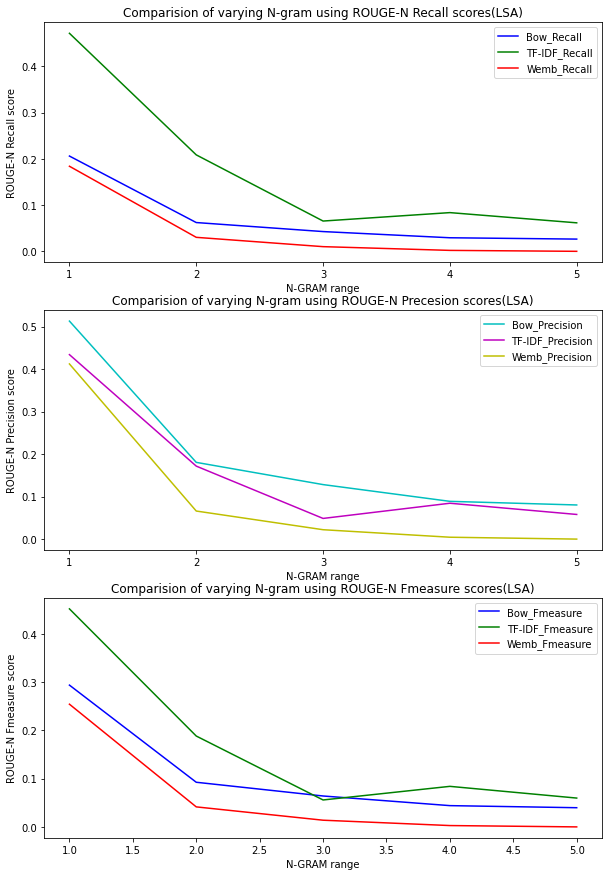

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

n_gram_range = [i for i in range(1,6)]

ax[0].plot(n_gram_range,lsa_comparision_df["BOW_Recall"],'b-', label="Bow_Recall")
ax[0].plot(n_gram_range,lsa_comparision_df["TF-IDF_Recall"],'g-', label="TF-IDF_Recall")
ax[0].plot(n_gram_range,lsa_comparision_df["W-Emb_Recall"],'r-', label="Wemb_Recall")
ax[0].title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(LSA)")
ax[0].set_xlabel("N-GRAM range")
ax[0].set_xticks(n_gram_range)
ax[0].set_ylabel("ROUGE-N Recall score")
ax[0].legend(loc="best")

ax[1].plot(n_gram_range,lsa_comparision_df["BOW_Precision"],'c-', label="Bow_Precision")
ax[1].plot(n_gram_range,lsa_comparision_df["TF-IDF_Precision"],'m-', label="TF-IDF_Precision")
ax[1].plot(n_gram_range,lsa_comparision_df["W-Emb_Precision"],'y-', label="Wemb_Precision")
ax[1].title.set_text("Comparision of varying N-gram using ROUGE-N Precesion scores(LSA)")
ax[1].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[1].set_ylabel("ROUGE-N Precision score")
ax[1].legend(loc="best")

ax[2].plot(n_gram_range,lsa_comparision_df["BOW_Fmeasure"],'b-', label="Bow_Fmeasure")
ax[2].plot(n_gram_range,lsa_comparision_df["TF-IDF_Fmeasure"],'g-', label="TF-IDF_Fmeasure")
ax[2].plot(n_gram_range,lsa_comparision_df["W-Emb_Fmeasure"],'r-', label="Wemb_Fmeasure")
ax[2].title.set_text("Comparision of varying N-gram using ROUGE-N Fmeasure scores(LSA)")
ax[2].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[2].set_ylabel("ROUGE-N Fmeasure score")
ax[2].legend(loc="best")

plt.show()

### LDA

In [ ]:
lda_comparision_df = pd.DataFrame()
lda_comparision_df["N-Gram Range"] = ["1-Gram", "2-Gram", "3-Gram", "4-Gram", "5-Gram"]

lda_comparision_df["BOW_Recall"] = [bow_lda_1gram_rouge.recall, bow_lda_2gram_rouge.recall, bow_lda_3gram_rouge.recall, bow_lda_4gram_rouge.recall, bow_lda_5gram_rouge.recall]
lda_comparision_df["TF-IDF_Recall"] = [tfidf_lda_1gram_rouge.recall, tfidf_lda_2gram_rouge.recall, tfidf_lda_3gram_rouge.recall, tfidf_lda_4gram_rouge.recall, tfidf_lda_5gram_rouge.recall]
lda_comparision_df["W-Emb_Recall"] = [wemb_lsa_1gram_rouge.recall, wemb_lda_2gram_rouge.recall, wemb_lda_3gram_rouge.recall, wemb_lda_4gram_rouge.recall, wemb_lda_5gram_rouge.recall]

lda_comparision_df["BOW_Precision"] = [bow_lda_1gram_rouge.precision, bow_lda_2gram_rouge.precision, bow_lda_3gram_rouge.precision, bow_lda_4gram_rouge.precision, bow_lda_5gram_rouge.precision]
lda_comparision_df["TF-IDF_Precision"] = [tfidf_lda_1gram_rouge.precision, tfidf_lda_2gram_rouge.precision, tfidf_lda_3gram_rouge.precision, tfidf_lda_4gram_rouge.precision, tfidf_lda_5gram_rouge.precision]
lda_comparision_df["W-Emb_Precision"] = [wemb_lda_1gram_rouge.precision, wemb_lda_2gram_rouge.precision, wemb_lda_3gram_rouge.precision, wemb_lda_4gram_rouge.precision, wemb_lda_5gram_rouge.precision]

lda_comparision_df["BOW_Fmeasure"] = [bow_lda_1gram_rouge.fmeasure, bow_lda_2gram_rouge.fmeasure, bow_lda_3gram_rouge.fmeasure, bow_lda_4gram_rouge.fmeasure, bow_lda_5gram_rouge.fmeasure]
lda_comparision_df["TF-IDF_Fmeasure"] = [tfidf_lda_1gram_rouge.fmeasure, tfidf_lda_2gram_rouge.fmeasure, tfidf_lda_3gram_rouge.fmeasure, tfidf_lda_4gram_rouge.fmeasure, tfidf_lda_5gram_rouge.fmeasure]
lda_comparision_df["W-Emb_Fmeasure"] = [wemb_lda_1gram_rouge.fmeasure, wemb_lda_2gram_rouge.fmeasure, wemb_lda_3gram_rouge.fmeasure, wemb_lda_4gram_rouge.fmeasure, wemb_lda_5gram_rouge.fmeasure]

lda_comparision_df

,N-Gram Range,BOW_Recall,TF-IDF_Recall,W-Emb_Recall,BOW_Precision,TF-IDF_Precision,W-Emb_Precision,BOW_Fmeasure,TF-IDF_Fmeasure,W-Emb_Fmeasure
0,1-Gram,0.175719,0.171875,0.183953,0.482456,0.434211,0.385965,0.257611,0.246269,0.290429
1,2-Gram,0.064771,0.033228,0.024169,0.180617,0.092511,0.035242,0.095349,0.048894,0.028674
2,3-Gram,0.043682,0.043956,0.009091,0.123894,0.123894,0.013274,0.064591,0.064890,0.010791
3,4-Gram,0.031898,0.030628,0.003040,0.088889,0.088889,0.004444,0.046948,0.045558,0.003610
4,5-Gram,0.028391,0.031696,0.000000,0.080357,0.089286,0.000000,0.041958,0.046784,0.000000


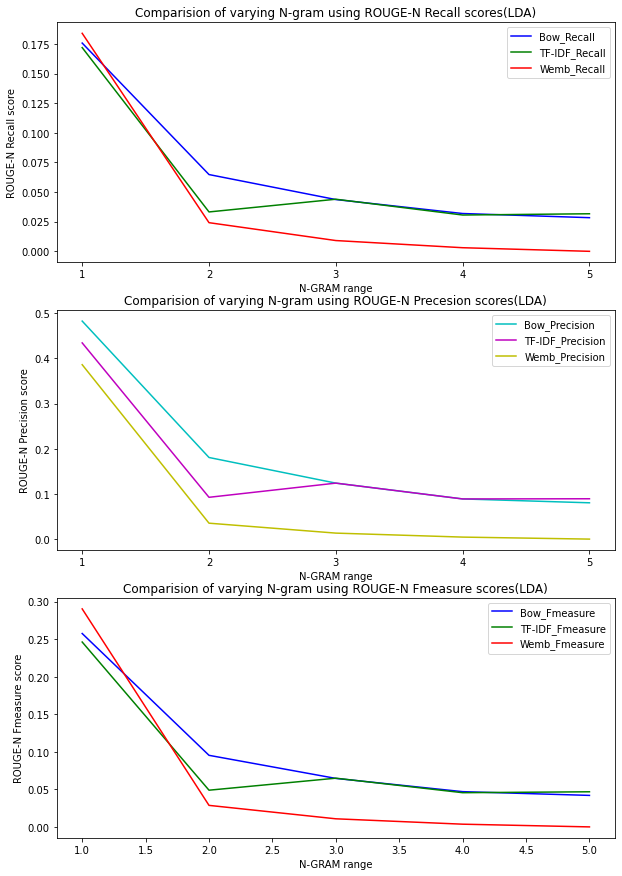

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(10,15))

n_gram_range = [i for i in range(1,6)]

ax[0].plot(n_gram_range,lda_comparision_df["BOW_Recall"],'b-', label="Bow_Recall")
ax[0].plot(n_gram_range,lda_comparision_df["TF-IDF_Recall"],'g-', label="TF-IDF_Recall")
ax[0].plot(n_gram_range,lda_comparision_df["W-Emb_Recall"],'r-', label="Wemb_Recall")
ax[0].title.set_text("Comparision of varying N-gram using ROUGE-N Recall scores(LDA)")
ax[0].set_xlabel("N-GRAM range")
ax[0].set_xticks(n_gram_range)
ax[0].set_ylabel("ROUGE-N Recall score")
ax[0].legend(loc="best")

ax[1].plot(n_gram_range,lda_comparision_df["BOW_Precision"],'c-', label="Bow_Precision")
ax[1].plot(n_gram_range,lda_comparision_df["TF-IDF_Precision"],'m-', label="TF-IDF_Precision")
ax[1].plot(n_gram_range,lda_comparision_df["W-Emb_Precision"],'y-', label="Wemb_Precision")
ax[1].title.set_text("Comparision of varying N-gram using ROUGE-N Precesion scores(LDA)")
ax[1].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[1].set_ylabel("ROUGE-N Precision score")
ax[1].legend(loc="best")

ax[2].plot(n_gram_range,lda_comparision_df["BOW_Fmeasure"],'b-', label="Bow_Fmeasure")
ax[2].plot(n_gram_range,lda_comparision_df["TF-IDF_Fmeasure"],'g-', label="TF-IDF_Fmeasure")
ax[2].plot(n_gram_range,lda_comparision_df["W-Emb_Fmeasure"],'r-', label="Wemb_Fmeasure")
ax[2].title.set_text("Comparision of varying N-gram using ROUGE-N Fmeasure scores(LDA)")
ax[2].set_xlabel("N-GRAM range")
ax[1].set_xticks(n_gram_range)
ax[2].set_ylabel("ROUGE-N Fmeasure score")
ax[2].legend(loc="best")

plt.show()

## Generate Features using Word-Embeddings (Next On Line)

## Reevalaute if word embeddings were generated properly (see if they were cumulated rather than, updated....  medain might work better than average...... see if the embedings can be generated as probabilites ...exponent or softmax or something)

# Genereate Summary for groud Truth by uisng TextRank Gensim

## LDA

In [2]:
from gensim.summarization.summarizer import summarize

ModuleNotFoundError: ignored

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1, 1))
feature_vector = tfidf_vectorizer.fit_transform(pp_article_st)
lda_model = LDA(n_components=N_LINE, random_state=0, max_iter = 50)
document_topic = lda_model.fit_transform(feature_vector)

In [ ]:
document_topic.shape

(595, 10)

In [ ]:
lda_model.components_.shape

(10, 3150)

In [ ]:
document_topic[0 : 5]

array([[0.02072168, 0.02071071, 0.02070818, 0.02074668, 0.81358038,
        0.02071362, 0.02070886, 0.02070441, 0.02070339, 0.0207021 ],
       [0.02152431, 0.02152846, 0.02152464, 0.02152595, 0.02152563,
        0.02152993, 0.02152312, 0.8062708 , 0.0215222 , 0.02152496],
       [0.0244328 , 0.02442974, 0.0244349 , 0.0244327 , 0.02443162,
        0.02443286, 0.02443735, 0.02443498, 0.78009677, 0.0244363 ],
       [0.02141273, 0.0214149 , 0.02142297, 0.02141523, 0.02141631,
        0.02141427, 0.80725614, 0.02141497, 0.02141324, 0.02141922],
       [0.02666964, 0.02666783, 0.75995876, 0.02667325, 0.02666786,
        0.02667204, 0.02666976, 0.02667287, 0.02666901, 0.02667898]])

In [ ]:
np.argmax(document_topic[0 : 5], axis = 1)

array([4, 7, 8, 6, 2])

In [ ]:
#sorted_probabilities = np.argsort(document_topic, axis = 1)[:,::-1]
sorted_probabilities = np.argsort(document_topic, axis = 1)

In [ ]:
sorted_probabilities.shape

(595, 10)

In [ ]:
sorted_probabilities[0 : 5]

array([[9, 8, 7, 2, 6, 1, 5, 0, 3, 4],
       [8, 6, 0, 2, 9, 4, 3, 1, 5, 7],
       [1, 4, 3, 0, 5, 2, 7, 9, 6, 8],
       [0, 8, 5, 1, 7, 3, 4, 9, 2, 6],
       [1, 4, 8, 0, 6, 5, 7, 3, 9, 2]])

In [ ]:
top_probabilities = sorted_probabilities[:,-1]

In [ ]:
top_probabilities[0:5]

array([4, 7, 8, 6, 2])

In [ ]:
from collections import defaultdict
topic_bins = defaultdict(list)

In [ ]:
for i in range(10):
  print(sorted_probabilities[i][-1], document_topic[i,sorted_probabilities[i][-1]])

4 0.8135803775862033
7 0.8062707996397139
8 0.7800967675447191
6 0.8072561448926678
2 0.7599587585378704
3 0.7464563322072268
0 0.8209721688214263
5 0.7781693909252522
6 0.8111930130605005
7 0.8432048499981545


In [ ]:
#sorted_probabilities.shape[0]
for i in range(10):
  topic_num = sorted_probabilities[i][-1]
  sent_index = i
  prob = document_topic[i,sorted_probabilities[i][-1]]
  topic_bins[topic_num].append((sent_index, prob))

In [ ]:
topic_bins

defaultdict(list,
            {0: [(6, 0.8209721688214263)],
             2: [(4, 0.7599587585378704)],
             3: [(5, 0.7464563322072268)],
             4: [(0, 0.8135803775862033)],
             5: [(7, 0.7781693909252522)],
             6: [(3, 0.8072561448926678), (8, 0.8111930130605005)],
             7: [(1, 0.8062707996397139), (9, 0.8432048499981545)],
             8: [(2, 0.7800967675447191)]})

In [ ]:
for k, v in topic_bins.items():
  topic_bins[k] = sorted(v, key=lambda x:x[1]) 

In [ ]:
topic_bins

defaultdict(list,
            {0: [(6, 0.8209721688214263)],
             2: [(4, 0.7599587585378704)],
             3: [(5, 0.7464563322072268)],
             4: [(0, 0.8135803775862033)],
             5: [(7, 0.7781693909252522)],
             6: [(3, 0.8072561448926678), (8, 0.8111930130605005)],
             7: [(1, 0.8062707996397139), (9, 0.8432048499981545)],
             8: [(2, 0.7800967675447191)]})

In [ ]:
topic_bins_keys = sorted(topic_bins.keys())
topic_bin_list = [None] * 10
for tindex in topic_bins_keys:
  topic_bin_list[tindex] = topic_bins[tindex]

In [ ]:
topic_bin_list

[[(6, 0.8209721688214263)],
 None,
 [(4, 0.7599587585378704)],
 [(5, 0.7464563322072268)],
 [(0, 0.8135803775862033)],
 [(7, 0.7781693909252522)],
 [(3, 0.8072561448926678), (8, 0.8111930130605005)],
 [(1, 0.8062707996397139), (9, 0.8432048499981545)],
 [(2, 0.7800967675447191)],
 None]

In [ ]:
sentences = []
index = 0
while index < 10:
  #index = index % len(topic_bin_list)
  if topic_bin_list[index]:
    sentences.append(topic_bin_list[index].pop())
  index += 1


In [ ]:
sentences

[(6, 0.8209721688214263),
 (4, 0.7599587585378704),
 (5, 0.7464563322072268),
 (0, 0.8135803775862033),
 (7, 0.7781693909252522),
 (8, 0.8111930130605005),
 (9, 0.8432048499981545),
 (2, 0.7800967675447191)]

In [ ]:
sentences = sorted(sentences, key=lambda x:x[0])

In [ ]:
sentences

[(0, 0.8135803775862033),
 (2, 0.7800967675447191),
 (4, 0.7599587585378704),
 (5, 0.7464563322072268),
 (6, 0.8209721688214263),
 (7, 0.7781693909252522),
 (8, 0.8111930130605005),
 (9, 0.8432048499981545)]

In [ ]:
summary = []
for idx, prob in sentences:
  summary.append(article_st[idx])

In [ ]:
summary

['\n\ncoordinates: .mw-parser-output .geo-default,.mw-parser-output .geo-dms,.mw-parser-output .geo-dec{display:inline}.mw-parser-output .geo-nondefault,.mw-parser-output .geo-multi-punct{display:none}.mw-parser-output .longitude,.mw-parser-output .latitude{white-space:nowrap}40°n 100°w\ufeff / \ufeff40°n 100°w\ufeff / 40; -100\nthe united states of america (u.s.a. or usa), commonly known as the united states (u.s. or us) or america, is a country primarily located in north america.',
 "[h] at 3.8\xa0million square miles (9.8\xa0million square kilometers), it is the world's third- or fourth-largest country by geographic area.",
 '[22] with a population of more than 331 million people, it is the third most populous country in the world.',
 'the national capital is washington, d.c., and the most populous city is new york city.',
 'paleo-indians migrated from siberia to the north american mainland at least 12,000 years ago, and european colonization began in the 16th century.',
 'the unite

In [ ]:
def generate_bow_summary(raw_sent_tokens, pp_sent_tokens, summary_size = 10, ngram_tuple=(1,1)):

  #get BOW Features
  count_vectorizer = CountVectorizer(ngram_range=ngram_tuple) #intialize
  feature_vector = count_vectorizer.fit_transform(pp_sent_tokens) #generate
  print("BOW Features Generated!!!")

  #get LDA features
  lda_model = LDA(n_components=summary_size, random_state=0, max_iter = 100)
  document_topic_vector = lda_model.fit_transform(feature_vector)
  print("LDA Features Generated!!!")

  #
  #generatee summaries based on LDA probabilibities
  #

  sorted_probabilities = np.argsort(document_topic, axis = 1) 
  top_probabilities = sorted_probabilities[:,-1]
  topic_bins = defaultdict(list)

  for i in range(document_topic_vector.shape[0]):
    topic_num = sorted_probabilities[i][-1]
    sent_index = i
    prob = document_topic_vector[i,sorted_probabilities[i][-1]]
    topic_bins[topic_num].append((sent_index, prob))

  print("Topic Bins Generated!!!")

  for k, v in topic_bins.items():
    topic_bins[k] = sorted(v, key=lambda x:x[1]) 

  topic_bins_keys = sorted(topic_bins.keys())
  topic_bin_list = [None] * document_topic_vector.shape[0]
  for tindex in topic_bins_keys:
    topic_bin_list[tindex] = topic_bins[tindex]

  print("Topic Bins List Generated!!!\n")

  sentences = []
  index = 0
  count = 0
  while count < N_LINE and topic_bin_list:
    index = index % len(topic_bin_list)
    if topic_bin_list[index]:
      sentences.append(topic_bin_list[index].pop())
      count += 1
    index += 1

  sentences = sorted(sentences, key=lambda x:x[0])
  summary = []
  for idx, prob in sentences:
    summary.append(article_st[idx])

  #return "".join(summary)
  return summary

In [ ]:
sum = generate_bow_summary(article_st, pp_article_st, summary_size = 20, ngram_tuple=(1,1))

BOW Features Generated!!!
LDA Features Generated!!!
Topic Bins Generated!!!
Topic Bins List Generated!!!



In [ ]:
sum

['in the late 18th century, the u.s. began expanding across north america, gradually obtaining new territories, sometimes through war, frequently displacing native americans, and admitting new states; by 1848, the united states spanned the continent.',
 '[24][25] in 1538, the flemish cartographer gerardus mercator used the name "america" on his own world map, applying it to the entire western hemisphere.',
 '[30]\nthe second draft of the articles of confederation, prepared by john dickinson and completed no later than june 17, 1776, declared "the name of this confederation shall be the \'united states of america\'.',
 '[44] anthropologist henry f. dobyns believed the populations were much higher, suggesting around 1.1 million along the shores of the gulf of mexico, 2.2 million people living between florida and massachusetts, 5.2 million in the mississippi valley and tributaries, and around 700,000 people in the florida peninsula.',
 'the ensuing war would become the deadliest military 